In [ ]:
"""
Created: 6/7

Purpose: To incorporate the synapses
into the neuron object

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")
sys.path.append("/meshAfterParty/meshAfterParty")

import datajoint_utils as du
from importlib import reload

In [3]:
# #configuring will include the adapters
# minnie,schema = du.configure_minnie_vm()

In [4]:
import neuron_utils as nru
import neuron_visualizations as nviz

# Downloading a Neuron to Play with

In [5]:
segment_id = 864691136194042326

In [ ]:
# original_mesh = du.fetch_segment_id_mesh(segment_id)

In [ ]:
# neuron_obj  = du.decomposition_with_spine_recalculation(segment_id,split_index = 0)

In [ ]:
# import synapse_utils as syu
# neuron_obj_syn = syu.add_synapses_to_neuron_obj(neuron_obj,
#                                                 segment_id = segment_id,
#                             validation = True,
#                             verbose  = True,
#                             #original_mesh = original_mesh,
#                             plot_valid_error_synapses = False,
#                             calculate_synapse_soma_distance = False,
#                             add_valid_synapses = True,
#                               add_error_synapses=False)

# Decompressing the Neuron to place with

In [6]:
import system_utils as su
original_mesh = su.decompress_pickle("original_mesh.pbz2")

In [7]:
neuron_obj = nru.decompress_neuron("./864691136194042326_0_25_axon_v5.pbz2",
                                  original_mesh=original_mesh)

Decompressing Neuron in minimal output mode...please wait


In [8]:
nviz.visualize_neuron(neuron_obj,
                     limb_branch_dict="all")

Recieved another instance of Neuron class in init -- so just copying data

 Working on visualization type: mesh

 Working on visualization type: skeleton
No Synapses to plot


In [9]:
neuron_obj_syn = neuron_obj

# The high degree function

In [ ]:
"""
Pseudocode: 


"""

In [12]:
import neuron_searching as ns
pre_filtering_limb_branch = ns.query_neuron_by_labels(neuron_obj,
                            matching_labels=["axon"])
nviz.plot_limb_branch_dict(neuron_obj,
                           pre_filtering_limb_branch)

Recieved another instance of Neuron class in init -- so just copying data

 Working on visualization type: mesh
No Synapses to plot


# finding all branches with at least 3 downstream branches

In [111]:
if pre_filtering_limb_branch is None:
    pre_filtering_limb_branch = neuron_obj.limb_branch_dict

    
skip_distance = 2000
min_skeletal_distance = 3000

high_degree_limb_branch = ns.query_neuron(neuron_obj,
                functions_list=["n_downstream_nodes_with_skip","skeletal_length"],
                query = f"(n_downstream_nodes_with_skip>2) and (skeletal_length>{min_skeletal_distance})",
                function_kwargs=dict(skip_distance=skip_distance),
               limb_branch_dict_restriction=pre_filtering_limb_branch)

nviz.plot_limb_branch_dict(neuron_obj,
                           high_degree_limb_branch)

Recieved another instance of Neuron class in init -- so just copying data

 Working on visualization type: mesh
No Synapses to plot


# Building the high degree matching

In [371]:
import axon_utils as au

"""
Purpose: To implement the high degree
branching filter using graph implementation
to compare the matches of all the candidates in 
a high degree branching area

Pseudocode: 
1) Get all downstream branhes (with an optional skip distance)
"""
limb_obj = neuron_obj[0]
branch_idx = 223
skip_distance = 3000
verbose = False
remove_short_thick_endnodes = True
short_thick_endnodes_to_remove = None
min_degree_to_resolve = 3

width_func = au.axon_width

max_degree_to_resolve = 6
max_degree_to_resolve_wide = 8
max_degree_to_resolve_width_threshold = 200


width_max = 170
axon_dependent = True

# --- parameters for the filtering away of edges ---
worst_case_match_threshold = 65

#args for width matching
width_diff_max = 75#np.inf,#100,
width_diff_perc = 60

verbose = True


#1) Get all downstream branhes (with an optional skip distance)
downstream_branches = cnu.endnode_branches_of_branches_within_distance_downtream(limb_obj,
                                                          branch_idx,
                                                          skip_distance=skip_distance)

if verbose:
    print(f"downstream_branches = {downstream_branches}")

if remove_short_thick_endnodes:
    if short_thick_endnodes_to_remove is None:
        short_thick_endnodes_to_remove = au.short_thick_branches_from_limb(limb_obj,
                             verbose = False)
    downstream_branches = np.setdiff1d(downstream_branches,short_thick_endnodes_to_remove)
    
    if verbose:
        print(f"downstream_branches after remove_short_thick_endnodes = {downstream_branches}")
        
        
if len(downstream_branches) < min_degree_to_resolve:
    if verbose:
        print(f"Number of branches ({len(downstream_branches)}), aka downstream_branches = {downstream_branches}) was less than min_degree_to_resolve ({min_degree_to_resolve}) so returning no error branches")
    return_value =  None,np.array([])
    
    
upstream_branch = branch_idx
if max_degree_to_resolve_wide is not None:
    up_width = width_func(limb_obj[upstream_branch])
    if up_width > max_degree_to_resolve_width_threshold:
        max_degree_to_resolve = max_degree_to_resolve_wide
        print(f"Changing max_degree_to_resolve = {max_degree_to_resolve_wide} because upstream width was {up_width} ")
        
if max_degree_to_resolve is not None and len(downstream_branches) > max_degree_to_resolve:
    if verbose:
        print(f"Number of branches ({len(downstream_branches)}) was more than max_degree_to_resolve ({max_degree_to_resolve}) so returning all downstream as error branches")
    return_value= None,downstream_branches
    

all_branch_idx = np.hstack([downstream_branches,[upstream_branch]])
    
widths_in_branches = np.array([width_func(limb_obj[b]) for b in all_branch_idx])
if verbose:
    print(f"widths_in_branches = {widths_in_branches}")

widths_in_branches = widths_in_branches[widths_in_branches != 0]

if width_max is not None:
    if len(widths_in_branches[widths_in_branches>width_max]) == len(widths_in_branches):
        if verbose:
            print(f"Returning No errors because widths are too thick for skeletons to be trusted")
        return_value = None,[]
        
if axon_dependent:
    for b in downstream_branches:
        if "axon" not in limb_obj[b].labels:
            if verbose:
                print(f"Returning No errors because not all branches were axons")
            return_value= None,[]
            
            
# create the full connected graph that stores the difference


downstream_branches = [225 226 227]
downstream_branches after remove_short_thick_endnodes = [225 226 227]
Changing max_degree_to_resolve = 8 because upstream width was 679.4556177211822 
widths_in_branches = [354.47255309 354.63438962 427.93966179 679.45561772]
Returning No errors because widths are too thick for skeletons to be trusted
Returning No errors because not all branches were axons
Returning No errors because not all branches were axons
Returning No errors because not all branches were axons


In [133]:
nru.find_parent_child_skeleton_angle_upstream_downstream(limb_obj,
                                                       223,
                                                       224,
                                                         branch_1_type="upstream",
                                                         branch_2_type="downstream",
                                                       plot_extracted_skeletons=True)

upstream 223 endpoint: [702663. 557074. 845507.]
downstream 224 endpoint: [711442. 565720. 845151.]
curr_angle = 19.8
Parent (223):red, child (224):blue


19.8

# Functions that will do a lot of the comparisons

In [249]:
import neuron
neuron_obj = neuron.Neuron(neuron_obj)
limb_obj = neuron_obj[0]

Recieved another instance of Neuron class in init -- so just copying data


In [416]:
G = complete_graph_from_node_ids(all_branch_idx)

nodes_to_compute = [upstream_branch]
edge_functions = dict(sk_angle=nst.parent_child_sk_angle,
                     width_diff = nst.width_diff,
                      width_diff_percentage = nst.width_diff_percentage,
                     synapse_density_diff=nst.synapse_density_diff,
                      n_synapses_diff = nst.n_synapses_diff,
                      none_to_some_synapses = nst.none_to_some_synapses
                     )

G_e_1 = nst.compute_edge_attributes_locally(G,
                                          limb_obj,
                                         nodes_to_compute,
                                         edge_functions,
                                         verbose=False,
                                         directional = False)

nodes_to_compute = downstream_branches
edge_functions = dict(sk_angle=nst.sibling_sk_angle,
                     width_diff = nst.width_diff,
                      width_diff_percentage = nst.width_diff_percentage,
                     synapse_density_diff=nst.synapse_density_diff,
                      n_synapses_diff = nst.n_synapses_diff,
                     none_to_some_synapses = nst.none_to_some_synapses)

G_e_2 = nst.compute_edge_attributes_locally(G_e_1,
                                          limb_obj,
                                         nodes_to_compute,
                                         edge_functions,
                                         verbose=False,
                                         directional = False)

xu.edge_df(G_e_2)

,u,v,sk_angle,width_diff,width_diff_percentage,synapse_density_diff,n_synapses_diff,none_to_some_synapses
0,225,226,88.99,0.161837,0.000456,0.000158,135,False
1,225,227,108.89,73.467109,0.171676,0.000205,6,False
2,225,223,119.20,324.983065,0.478299,0.000264,25,False
3,226,227,102.61,73.305272,0.171298,0.000047,129,False
4,226,223,140.22,324.821228,0.478061,0.000106,160,False
5,227,223,134.21,251.515956,0.370173,0.000059,31,False


# Doing the Edge Query

branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 108))and ((synapse_density_diff<0.0002) or (n_synapses_diff < 6))



Performing Edge Query
After edge filter, # of rows = 2


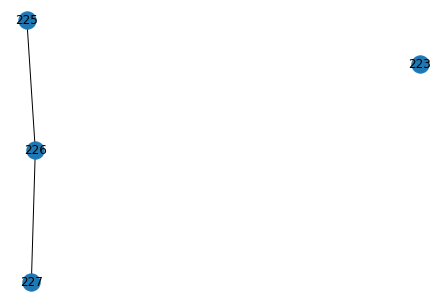

In [417]:
# --- parameters for the filtering away of edges ---
worst_case_match_threshold = 108

#args for width matching
width_diff_max = 75#np.inf,#100,
width_diff_perc = 0.60

perform_synapse_filter = True
synapse_density_diff_threshold = 0.0002
n_synapses_diff_threshold = 6

plot_G_edge_filt = True

synapse_query = (f"((synapse_density_diff<{synapse_density_diff_threshold}) or" 
                    f" (n_synapses_diff < {n_synapses_diff_threshold}))")

branch_match_query = (f"(((width_diff < {width_diff_max}) or (width_diff_percentage < {width_diff_perc}))"
                      f" and (sk_angle < {worst_case_match_threshold}))")

if perform_synapse_filter:
    branch_match_query += f"and {synapse_query}"
    
if verbose:
    print(f"branch_match_query = :\n{branch_match_query}")
    
G_edge_filt = xu.query_to_subgraph(G_e_2,
                                  edge_query=branch_match_query,
                                  verbose=True)
if plot_G_edge_filt:
    nx.draw(G_edge_filt,with_labels=True)

# Do global features

In [418]:
xu.edge_df(G_edge_filt)

,u,v,sk_angle,width_diff,width_diff_percentage,synapse_density_diff,n_synapses_diff,none_to_some_synapses
0,225,226,88.99,0.161837,0.000456,0.000158,135,False
1,226,227,102.61,73.305272,0.171298,0.000047,129,False


In [419]:
edge_functions_global = dict(definite_partner_delete=dict(function=nst.edges_to_delete_from_threshold_and_buffer,
                                                          arguments=dict(threshold=100,
                                                                              buffer= 13,
                                                                       verbose = False))
                     )
# applying the definite filter pair
G_edge_filt_with_att = nst.compute_edge_attributes_globally(G_edge_filt,
                                     edge_functions_global)
G_global_1 = xu.query_to_subgraph(G_edge_filt_with_att,
                                  edge_query="definite_partner_delete != True",
                                  verbose=True)

xu.edge_df(G_global_1)


Performing Edge Query
After edge filter, # of rows = 1


,u,v,sk_angle,width_diff,width_diff_percentage,synapse_density_diff,n_synapses_diff,none_to_some_synapses,definite_partner_delete
0,225,226,88.99,0.161837,0.000456,0.000158,135,False,None


In [420]:
edge_functions_node_global = dict(above_threshold_delete=dict(
                                function=nst.edges_to_delete_on_node_above_threshold_if_one_below,
                                arguments=dict(threshold=90,
                                   verbose = True)
                                )
                     )
# applying the definite filter pair
G_edge_filt_with_node_att = nst.compute_edge_attributes_around_node(G_edge_filt,
                                     edge_functions_node_global,
                                        nodes_to_compute=225,
                                     )

G_global_2 = xu.query_to_subgraph(G_edge_filt_with_node_att,
                                  edge_query="above_threshold_delete != True",
                                  verbose=True)


for edge_values = [88.99] 
n_below_match = 1 (with threshold = 90)
edges_to_delete = []



Performing Edge Query
After edge filter, # of rows = 2


# Doing the definite pairs (where you iterate over the different edges and see if it is the best candidate edge based on threshold and buffer)

In [341]:
xu.compute_edge_attributes_globally

<function networkx_utils.compute_edge_attributes_globally(G, edge_functions, edges_to_compute=None, verbose=False, directional=False, **kwargs)>

In [339]:
# import copy
# def edges_to_delete_from_threshold_and_buffer(G,
#                                               u,
#                                               v,
#                                         edge_attribute="sk_angle",
#                                         threshold = 45,
#                                         buffer = 15,
#                                        verbose = False,
#                                              **kwargs):
#     """
#     4) Create definite pairs by looking for edges that meet:
#     - match threshold
#     - have buffer better than other edges
#     ** for those edges, eliminate all edges on those
#     2 nodes except that edge

#     Pseudocode: 
#     Iterate through each edge:
#     a) get the current weight of this edge
#     b) get all the other edges that are touching the two nodes and their weights
#     c) Run the following test on the edge:
#        i) Is it in the match limit
#        ii) is it less than other edge weightbs by the buffer size
#     d) If pass the tests then delete all of the other edges from the graph
#     """
#     e = [u,v]
    
#     other_edges_to_remove = []
#     e = np.sort(e)
#     if verbose:
#         print(f"--Working on edge {e}--")
#     #e_weight = xu.get_edge_weight(G,e)
#     e_weight = G[e[0]][e[1]][edge_attribute]
#     all_edges = np.unique(
#                 np.sort(
#                 np.array(xu.node_to_edges(G,e[0]) + xu.node_to_edges(G,e[1])),axis=1)
#                 ,axis=0)


#     #b) get all the other edges that are touching the two nodes and their weights
#     other_edges = nu.setdiff2d(all_edges,e.reshape(-1,2))

#     if len(other_edges) == 0:
#         other_edge_min = np.inf
#     else:
#         other_edge_weights = [G[edg[0]][edg[1]][edge_attribute] for edg in other_edges]
#         other_edge_min = np.min(other_edge_weights)

#     edge_buffer = other_edge_min - e_weight
#     if e_weight <= threshold and edge_buffer > buffer:
#         if verbose:
#             print(f"Edge {e} is matches definite match threshold with: "
#                  f"\nEdge Buffer of {edge_buffer} (buffer = {buffer})"
#                  f"\nEdge distane of {e_weight} (threshold = {threshold})")
#         other_edges_to_remove += list(other_edges)
        
#     return edge_attribute_dict_from_edges_to_delete(other_edges_to_remove)

# # if verbose:
# #     print(f"Step 4: Definite Edges")
# #     print(f"Remaining Edges = {G.edges()}, Remaining Nodes = {G.nodes()}")
# # #     nx.draw(G,with_labels=True)
# # #     plt.show()

# edges_to_delete = edges_to_delete_from_threshold_and_buffer(G,
#                                                             225,
#                                                             226,
#                                           threshold=100,
#                                           buffer= 13,
#                                          verbose = True)
# edges_to_delete
# # G_cp = copy.deepcopy(G)
# # G_cp.remove_edges_from(edges_to_delete)
# # nx.draw(G_cp,with_labels = True)

--Working on edge [225 226]--
Edge [225 226] is matches definite match threshold with: 
Edge Buffer of 13.620000000000005 (buffer = 13)
Edge distane of 88.99 (threshold = 100)


{223: {225: True, 226: True}, 225: {227: True}, 226: {227: True}}

   Working on Edge [225 226]
--Working on edge [225 226]--
Edge [225 226] is matches definite match threshold with: 
Edge Buffer of 13.620000000000005 (buffer = 13)
Edge distane of 88.99 (threshold = 100)
      definite_partner_delete: {223: {225: True, 226: True}, 225: {227: True}, 226: {227: True}}
   Working on Edge [225 227]
--Working on edge [225 227]--
      definite_partner_delete: {}
   Working on Edge [225 223]
--Working on edge [223 225]--
      definite_partner_delete: {}
   Working on Edge [226 227]
--Working on edge [226 227]--
      definite_partner_delete: {}
   Working on Edge [226 223]
--Working on edge [223 226]--
      definite_partner_delete: {}
   Working on Edge [227 223]
--Working on edge [223 227]--
      definite_partner_delete: {}


In [351]:
xu.edge_df(G)

,u,v,sk_angle,width_diff,width_diff_percentage,synapse_density_diff,n_synapses_diff,none_to_some_synapses,definite_partner_delete
0,225,226,88.99,0.161837,0.000456,0.000158,135,False,NaN
1,225,227,108.89,73.467109,0.171676,0.000205,6,False,True
2,225,223,119.20,324.983065,0.478299,0.000264,25,False,True
3,226,227,102.61,73.305272,0.171298,0.000047,129,False,True
4,226,223,140.22,324.821228,0.478061,0.000106,160,False,True
5,227,223,134.21,251.515956,0.370173,0.000059,31,False,NaN


In [329]:
import pandas_utils as pu
df = pu.dicts_to_dataframe([dict(a = 5,b = 10),dict(a = 10,c = 7)])
df

,a,b,c
0,5,10.0,NaN
1,10,NaN,7.0


In [335]:
xu.edges(G)

array([[225, 226],
       [225, 227],
       [225, 223],
       [226, 227],
       [226, 223],
       [227, 223]])

# Doing the Global Graph Metrics (not yet implemented)

In [ ]:
"""
Purpose: To apply edge attributes 
that are computed based on the
other edges existing that are 
connected to that node

Pseudocode: 
1) Iterate through all of the nodes:
    Identify all of the edges in connected to that node
    
    2) Send all of the edges and their attributes to
       a function that will compute another attribute
       based on the existing attributes
       
    3) Store the new attribute in the edges
    
Application: Can then query the graph based on this new 
feature
"""
global_edge_functions = dict

for n in G.nodes():
    edge_attr_dict = xu.edge_attribute_dict_from_node(G,n)
    

In [317]:
"""
Purpose: To find how much farther above/below
extrema certain attributes are

"""
def buffer_from_extrema()

{226: {'sk_angle': 88.99,
  'width_diff': 0.16183652379322666,
  'width_diff_percentage': 0.0004563475188275387,
  'synapse_density_diff': 0.00015843221238654912,
  'n_synapses_diff': 135,
  'none_to_some_synapses': False},
 227: {'sk_angle': 108.89,
  'width_diff': 73.46710869978193,
  'width_diff_percentage': 0.17167632556362325,
  'synapse_density_diff': 0.00020538992025757787,
  'n_synapses_diff': 6,
  'none_to_some_synapses': False},
 223: {'sk_angle': 119.2,
  'width_diff': 324.98306462668245,
  'width_diff_percentage': 0.4782991797413334,
  'synapse_density_diff': 0.000264054082784641,
  'n_synapses_diff': 25,
  'none_to_some_synapses': False}}

In [311]:
G.nodes()

NodeView((225, 226, 227, 223))

In [286]:
ex_query = f"((n_synapses_diff<{10}) or (synapse_density_diff < 0.0002))"

print(ex_query)
print(f"synapse_query = {synapse_query}")
xu.edge_df(G).query(synapse_query)

((n_synapses_diff<10) or (synapse_density_diff < 0.0002))
synapse_query = ((n_synapses_diff<0.0003) or (n_synapses_diff < 10))


,u,v,sk_angle,width_diff,width_diff_percentage,synapse_density_diff,n_synapses_diff,none_to_some_synapses
1,225,227,108.89,73.467109,0.171676,0.000205,6,False


# Building the Initial Query

branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 150))and ((synapse_density_diff<3e-05) or (n_synapses_diff < 50))



Performing Edge Query
After edge filter, # of rows = 3


In [292]:
xu.edge_df(G_edge_filt)

,u,v,sk_angle,width_diff,width_diff_percentage,synapse_density_diff,n_synapses_diff,none_to_some_synapses
0,225,227,108.89,73.467109,0.171676,0.000205,6,False
1,225,223,119.20,324.983065,0.478299,0.000264,25,False
2,227,223,134.21,251.515956,0.370173,0.000059,31,False


In [290]:
xu.edge_df(G)

,u,v,sk_angle,width_diff,width_diff_percentage,synapse_density_diff,n_synapses_diff,none_to_some_synapses
0,225,226,88.99,0.161837,0.000456,0.000158,135,False
1,225,227,108.89,73.467109,0.171676,0.000205,6,False
2,225,223,119.20,324.983065,0.478299,0.000264,25,False
3,226,227,102.61,73.305272,0.171298,0.000047,129,False
4,226,223,140.22,324.821228,0.478061,0.000106,160,False
5,227,223,134.21,251.515956,0.370173,0.000059,31,False


In [ ]:
import networkx as nx
nx.draw(G_edge_filt,with_labels=True)

In [200]:
branch_idx = 140
nru.find_parent_child_skeleton_angle_upstream_downstream(limb_obj,
                                                        nru.upstream_node(limb_obj,branch_idx),branch_idx,
                                                        verbose = True,
                                                        plot_extracted_skeletons=True,
                                                        comparison_distance=40000,
                                                        use_upstream_skeleton_restriction=True)

upstream 139 endpoint: [721098.  531071.2 762870.4]
restriction function
downstream 140 endpoint: [721098.  531071.2 762870.4]
curr_angle = 21.46
Parent (139):red, child (140):blue


21.46

In [ ]:
offset=1500,
comparison_distance = 2000,
worst_case_match_threshold = 65,

#args for width matching
width_diff_max = 75,#np.inf,#100,
width_diff_perc = 60,

#args for definite pairs
match_threshold = 45,
angle_buffer = 15,

max_degree_to_resolve = 6,
max_degree_to_resolve_wide = 8,

#args for picking the final winner
match_method = "best_match", #other option is "best_match"

kiss_check = True,
kiss_check_bbox_longest_side_threshold = 450,

In [67]:
[k for k in dir(nru) if "dist" in k]

['branch_skeletal_distance_from_soma',
 'branches_within_skeletal_distance',
 'distance_to_soma_from_coordinate_close_to_branch',
 'global_comparison_distance',
 'skeletal_distance_from_soma',
 'synapse_skeletal_distances_to_soma']

# Filtering the Neuron and then adding back the errors

In [ ]:
import proofreading_utils as pru
o_neuron, filtering_info = pru.apply_proofreading_filters_to_neuron(input_neuron = neuron_obj,
                                        filter_list = pru.v5_exc_filters(),
                                        plot_limb_branch_filter_with_disconnect_effect=False,
                                        plot_limb_branch_filter_away=False,
                                        plot_final_neuron=False,

                                        return_error_info=True,
                                         verbose=True,
                                        verbose_outline=True,
                                        return_limb_branch_dict_to_cancel = True)
nviz.visualize_neuron(o_neuron,limb_branch_dict="all")

In [ ]:
import neuron
o_neuron_cp = neuron.Neuron(o_neuron)
syu.add_synapses_to_neuron_obj(o_neuron_cp,
                            validation = True,
                            verbose  = True,
                            original_mesh = original_mesh,
                            plot_valid_error_synapses = False,
                            calculate_synapse_soma_distance = False,
                            add_valid_synapses = False,
                              add_error_synapses=True)
o_neuron_cp.n_synapses_total

# How to Query Synapses

In [ ]:
syu.synapses_df(neuron_obj)

ret_df = syu.query_synapses(neuron_obj,
query = "label == 'soma'",
verbose = True,
return_index = True)

ret_df